# Reproducibility of physiological aging rates (PARs) across time
This notebook contains code for comparing 10,000 training-testing split PARs from different timepoints in the SardiNIA and inCHIANTI studies (e.g. comparison between two of the four waves in each study). Code for visualizing the averaged trend and for plotting individual trajectories by wave and by age are included.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from scipy.stats import pearsonr
import pandas as pd
import glob as gb
import csv

colors = ['#324851', '#86AC41', '#34675C', '#7DA3A1']

In [2]:
def plotComparison (data_file_x, data_file_y, save_name, bound='none', rescale='none', 
                    save='yes', show='yes', x_label=None, y_label=None, dpi=800):
    '''
    Function for comparing results across two results files
    Can specify if 'bound' for trimmed data according to bound=[min,max]
    Can specify if 'rescale' = 'linear' for linearly rescaled PAR values
    Will save plots of physiological age X vs physiological age Y and of PAR X vs PAR Y
    '''
    colors = ['#324851', '#86AC41', '#34675C', '#7DA3A1']
    try:
        data_x = np.genfromtxt('./Results/'+data_file_x+'.tsv', delimiter='\t')
    except:
        data_x = np.genfromtxt('./Results/'+data_file_x+'.csv', delimiter=',')
    try:
        data_y = np.genfromtxt('./Results/'+data_file_y+'.tsv', delimiter='\t')
    except:
        data_y = np.genfromtxt('./Results/'+data_file_y+'.csv', delimiter=',')

    x_ids = data_x[:,0]
    order_x = np.argsort(x_ids)
    y_ids = data_y[:,0]
    order_y = np.argsort(y_ids)

    # actual ages
    act_x = data_x[:,1]
    act_y = data_y[:,1]
    
    # predicted ages
    pred_x = data_x[:,2]
    pred_y  = data_y[:,2]
    
    if rescale == 'linear':
        fit_x = np.polyfit(act_x,pred_x,1)
        fit_fn_x = np.poly1d(fit_x)
        slope_x, intercept_x = np.polyfit(act_x, fit_fn_x(act_x),1)
        pred_x = linearRescale(pred_x, slope_x, intercept_x)
        
        fit_y = np.polyfit(act_y,pred_y,1)
        fit_fn_y = np.poly1d(fit_y)
        slope_y, intercept_y = np.polyfit(act_y, fit_fn_y(act_y),1)
        pred_y = linearRescale(pred_y, slope_y, intercept_y)
    
    elif rescale == 'linear_x':
        fit_x = np.polyfit(act_x,pred_x,1)
        fit_fn_x = np.poly1d(fit_x)
        slope_x, intercept_x = np.polyfit(act_x, fit_fn_x(act_x),1)
        pred_x = linearRescale(pred_x, slope_x, intercept_x)
        
    elif rescale == 'linear_y':
        fit_y = np.polyfit(act_y,pred_y,1)
        fit_fn_y = np.poly1d(fit_y)
        slope_y, intercept_y = np.polyfit(act_y, fit_fn_y(act_y),1)
        pred_y = linearRescale(pred_y, slope_y, intercept_y)
        
    
    # rates
    rates_x = np.array(pred_x)/np.array(act_x)
    rates_y  = np.array(pred_y)/np.array(act_y)

    x_rates = []
    y_rates = []
    x_act = []
    y_act = []
    x_pred = []
    y_pred = []

    # Find identities in both sets and order them correspondingly
    for identity in y_ids:
        if identity in x_ids:
            xidx = np.where(x_ids==identity)
            yidx = np.where(y_ids==identity)
            if np.isnan(rates_x[xidx]) or np.isnan(rates_y[yidx]) or np.isnan(pred_x[xidx]) or np.isnan(pred_y[yidx]) or np.isnan(act_y[yidx]) or np.isnan(act_x[xidx]):
                continue
            else:
                x_rates.append(float(rates_x[xidx]))
                y_rates.append(float(rates_y[yidx]))
                x_pred.append(float(pred_x[xidx]))
                y_pred.append(float(pred_y[yidx]))
                x_act.append(float(act_x[xidx]))
                y_act.append(float(act_y[yidx]))

    x_rates = np.array(x_rates)
    y_rates = np.array(y_rates)
    x_act = np.array(x_act)
    y_act = np.array(y_act)
    x_pred = np.array(x_pred)
    y_pred = np.array(y_pred)
                
    if bound == 'none':
        pl.figure(figsize=(5,5))
        pl.title('Physiological Aging Rate', fontsize=14)
        fit = np.polyfit(x_rates,y_rates,1)
        fit_fn = np.poly1d(fit)
        slope, intercept = np.polyfit(x_rates, fit_fn(x_rates),1)
        pl.plot(x_rates, y_rates, marker='o', linestyle='', markerfacecolor=colors[3], alpha=0.05)
        pl.plot(x_rates, fit_fn(x_rates), '--k', alpha=0.1)
        pearson, p = pearsonr(x_rates,y_rates)
        pl.annotate('$R^2$ = '+str("%.3f" %(pearson*pearson)), xy=(0.65, 0.25), xycoords='axes fraction', fontsize=11)
        pl.annotate('Slope = '+str("%.2f" %slope), xy=(0.65, 0.175), xycoords='axes fraction', fontsize=11)
        pl.annotate('y-intercept = '+str("%.2f" %intercept), xy=(0.65, 0.1), xycoords='axes fraction', fontsize=11)
        pl.plot([-0.05,2.05], [-0.05,2.05], 'k')
        pl.xlim(-0.05,2.05)
        pl.ylim(-0.05,2.05)
        if x_label is None:
            pl.xlabel(data_file_x)
        else:
            pl.xlabel(x_label, fontsize=14)
            pl.tick_params(axis='both', which='major', labelsize=12)
            pl.tick_params(axis='both', which='minor', labelsize=12)
        if y_label is None:
            pl.ylabel(data_file_y)
        else:
            pl.ylabel(y_label, fontsize=14)
            pl.tick_params(axis='both', which='major', labelsize=12)
            pl.tick_params(axis='both', which='minor', labelsize=12)
        if save == 'yes':
            pl.tight_layout()
            pl.savefig('./Figures/Comparisons/'+save_name+'_rates.png', format='png', dpi=dpi)
        if show == 'yes':
            pl.show()

        pl.figure(figsize=(5,5))
        if rescale == 'none':
            pl.title('Physiological Age', fontsize=14)
        else:
            pl.title('Physiological Age', fontsize=14)
        fit = np.polyfit(x_pred,y_pred,1)
        fit_fn = np.poly1d(fit)
        slope, intercept = np.polyfit(x_pred, fit_fn(x_pred),1)
        pl.plot(x_pred, y_pred, marker='o', linestyle='', markerfacecolor=colors[3], alpha=0.05)
        pl.plot(x_pred, fit_fn(x_pred), '--k', alpha=0.1)
        pearson, p = pearsonr(x_pred,y_pred)
        pl.annotate('$R^2$ = '+str("%.3f" %(pearson*pearson)), xy=(0.65, 0.25), xycoords='axes fraction', fontsize=11)
        pl.annotate('Slope = '+str("%.2f" %slope), xy=(0.65, 0.175), xycoords='axes fraction', fontsize=11)
        pl.annotate('y-intercept = '+str("%.2f" %intercept), xy=(0.65, 0.1), xycoords='axes fraction', fontsize=11)    
        pl.plot([10,95], [10,95], 'k')
        if x_label is None:
            pl.xlabel(data_file_x)
        else:
            pl.xlabel(x_label, fontsize=14)
            pl.tick_params(axis='both', which='major', labelsize=12)
            pl.tick_params(axis='both', which='minor', labelsize=12)
        if y_label is None:
            pl.ylabel(data_file_y)
        else:
            pl.ylabel(y_label, fontsize=14)
            pl.tick_params(axis='both', which='major', labelsize=12)
            pl.tick_params(axis='both', which='minor', labelsize=12)
        if save == 'yes':
            pl.tight_layout()
            pl.savefig('./Figures/Comparisons/'+save_name+'_pred.png', format='png', dpi=dpi)
        if show == 'yes':
            pl.show()
        
    else: # BOUND CONDITION
        lower_bound = bound[0]
        upper_bound = bound[1]
        # actual ages should be the same now
        middle_idxs = np.where((x_act >= lower_bound) & (x_act <= upper_bound))
        edge_idxs = np.where((x_act < lower_bound) | (x_act > upper_bound))
        middle_x_pred = x_pred[middle_idxs]
        middle_y_pred = y_pred[middle_idxs]
        edge_x_pred = x_pred[edge_idxs]
        edge_y_pred = y_pred[edge_idxs]
        middle_x_rates = x_rates[middle_idxs]
        middle_y_rates = y_rates[middle_idxs]
        edge_x_rates = x_rates[edge_idxs]
        edge_y_rates = y_rates[edge_idxs]
        
        
        pl.figure(figsize=(5,5))
        fit = np.polyfit(middle_x_rates,middle_y_rates,1)
        fit_fn = np.poly1d(fit)
        slope, intercept = np.polyfit(middle_x_rates, fit_fn(middle_x_rates),1)
        pl.plot(middle_x_rates, middle_y_rates, marker='o', markerfacecolor=colors[3], linestyle='', alpha=0.05)
        pl.plot(middle_x_rates, fit_fn(middle_x_rates), '--k', alpha=0.1)
        pl.plot(middle_x_rates, middle_y_rates, marker='o', markerfacecolor=colors[0], linestyle='', alpha=0.05)
        pearson, p = pearsonr(middle_x_rates,middle_y_rates)
        pl.annotate('Bound = ' + '['+str(bound[0])+' ,'+str(bound[1])+']', xy=(0.65, 0.325), xycoords='axes fraction', fontsize=11)
        pl.annotate('$R^2$ = '+str("%.3f" %(pearson*pearson)), xy=(0.65, 0.25), xycoords='axes fraction', fontsize=11)
        pl.annotate('Slope = '+str("%.2f" %slope), xy=(0.65, 0.175), xycoords='axes fraction', fontsize=11)
        pl.annotate('y-intercept = '+str("%.2f" %intercept), xy=(0.65, 0.1), xycoords='axes fraction', fontsize=11)
        pl.plot([-0.05,2.05], [-0.05,2.05], 'k')
        pl.xlim(-0.05,2.05)
        pl.ylim(-0.05,2.05)
        pl.title('Physiological Aging Rate', fontsize=14)
        if x_label is None:
            pl.xlabel(data_file_x)
        else:
            pl.xlabel(x_label, fontsize=14)
            pl.tick_params(axis='both', which='major', labelsize=12)
            pl.tick_params(axis='both', which='minor', labelsize=12)
        if y_label is None:
            pl.ylabel(data_file_y)
        else:
            pl.ylabel(y_label, fontsize=14)
            pl.tick_params(axis='both', which='major', labelsize=12)
            pl.tick_params(axis='both', which='minor', labelsize=12)
        #pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        #pl.legend(loc="upper left")
        if save == 'yes':
            pl.tight_layout()
            pl.savefig('./Figures/Comparisons/'+save_name+'_rates_bound.png', format='png', dpi=dpi)
        if show == 'yes':
            pl.show()

        pl.figure(figsize=(5,5))
        fit = np.polyfit(middle_x_pred,middle_y_pred,1)
        fit_fn = np.poly1d(fit)
        slope, intercept = np.polyfit(middle_x_pred, fit_fn(middle_x_pred),1)
        pl.plot(middle_x_pred, middle_y_pred, marker='o', markerfacecolor=colors[3], linestyle='', alpha=0.05)
        pl.plot(middle_x_pred, fit_fn(middle_x_pred), '--k', alpha=0.1)
        pl.plot(edge_x_pred, edge_y_pred, marker='o', markerfacecolor=colors[0], linestyle='', alpha=0.05)
        pearson, p = pearsonr(middle_x_pred,middle_y_pred)
        pl.annotate('Bound = ' + '['+str(bound[0])+' ,'+str(bound[1])+']', xy=(0.65, 0.325), xycoords='axes fraction', fontsize=11)
        pl.annotate('$R^2$ = '+str("%.3f" %(pearson*pearson)), xy=(0.65, 0.25), xycoords='axes fraction', fontsize=11)
        pl.annotate('Slope = '+str("%.2f" %slope), xy=(0.65, 0.175), xycoords='axes fraction', fontsize=11)
        pl.annotate('y-intercept = '+str("%.2f" %intercept), xy=(0.65, 0.1), xycoords='axes fraction', fontsize=11)    
        pl.plot([10,95], [10,95], 'k')
        pl.title('Physiological Age', fontsize=14)
        if x_label is None:
            pl.xlabel(data_file_x)
        else:
            pl.xlabel(x_label, fontsize=14)
            pl.tick_params(axis='both', which='major', labelsize=12)
            pl.tick_params(axis='both', which='minor', labelsize=12)
        if y_label is None:
            pl.ylabel(data_file_y)
        else:
            pl.ylabel(y_label, fontsize=14)
            pl.tick_params(axis='both', which='major', labelsize=12)
            pl.tick_params(axis='both', which='minor', labelsize=12)
        #pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        pl.legend(loc="upper left")
        if save == 'yes':
            pl.tight_layout()
            pl.savefig('./Figures/Comparisons/'+save_name+'_pred_bound.png', format='png', dpi=dpi)
        if show == 'yes':
            pl.show()

In [3]:
def plotWaves (dir_path, title, plot_num, start_idx, save_name, rescale='none', bound='no'):
    '''
    Function for plotting individual PAR trajectories with respect to the study wave number (1-4)
    Will plot "plot_num" trajectories starting at indiviudal "start_idx"
    '''
    import matplotlib.cm as cm
    import matplotlib as mpl
    
    predicted_dict = {}
    chron_dict = {}
    rate_dict = {}
    
    num_waves = 0
    
    for count, file in enumerate(gb.glob(dir_path+'*.tsv'), 1):
        results_data = np.loadtxt(file, delimiter='\t')
        ids = results_data[:,0]
        chrons = results_data[:,1]
        preds = results_data[:,2]
        rates = results_data[:,3]
        
        if bound is not 'no':
            lower_bound = bound[0]
            upper_bound = bound[1]
            middle_idxs = np.where((chrons >= lower_bound) & (chrons <= upper_bound))
            ids = ids[middle_idxs]
            chrons = chrons[middle_idxs]
            preds = preds[middle_idxs]
            rates = rates[middle_idxs]
        
        # linear rescaling
        if rescale == 'linear':
            fit = np.polyfit(chrons,preds,1)
            fit_fn = np.poly1d(fit)
            slope, intercept = np.polyfit(chrons, fit_fn(chrons),1)
            preds = linearRescale(preds, slope, intercept)
            rates = np.array(preds)/chrons
        
        num_waves += 1
        
        for idx, participant in enumerate(ids):
            if participant not in predicted_dict:
                predicted_dict[participant] = []
                chron_dict[participant] = []
                rate_dict[participant] = []
            predicted_dict[participant].append(preds[idx])
            chron_dict[participant].append(chrons[idx])
            rate_dict[participant].append(rates[idx])
    
    chronological_ages = []
    aging_rates = []
    participant_ids = []
    ind_stds = []
    
    for key, value in predicted_dict.items():
        if len(predicted_dict[key]) == num_waves:
            participant_ids.append(int(key))
            chronological_ages.append(chron_dict[key])
            aging_rates.append(rate_dict[key])
            ind_stds.append(np.std(rate_dict[key]))
            
    std = round(np.mean(ind_stds), 3)
    
    ax = pl.figure(figsize=(10,5)).gca() #figsize=(4,4)
    i = start_idx
    while i < start_idx+plot_num:
        chrons = chronological_ages[i]
        y = aging_rates[i]
        sorted_chrons, sorted_y = zip(*sorted(zip(chrons, y)))
        leg_label = str(participant_ids[i])
        # CMAP
        norm = mpl.colors.Normalize(vmin=0.5, vmax=2.0)
        cmap = cm.viridis
        #cmap = cm.inferno
        rate = sorted_y[0]
        m = cm.ScalarMappable(norm=norm, cmap=cmap)
        color = m.to_rgba(rate)
        ax.plot([1,2,3,4], sorted_y, color=color, linewidth=3.0, alpha=0.2, label=leg_label)
        i += 1

    from matplotlib.ticker import MaxNLocator
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    pl.ylim([0.5,2])
    pl.xlim([0.99,4.01])
    pl.xlabel('SardiNIA Wave Number',fontsize=14)
    pl.ylabel('Physiological Aging Rate',fontsize=14)
    pl.title(title)
    if plot_num < 5:
        pl.legend()
    pl.annotate('$\sigma_{\mathregular{PAR}}$ = '+str(std), xy=(0.1, 0.9), xycoords='axes fraction', fontsize=11)
    pl.tick_params(axis='both', which='major', labelsize=12)
    pl.tick_params(axis='both', which='minor', labelsize=12)
    sc = pl.scatter(np.linspace(2,3,10),np.linspace(0.7,1.5,10),c=np.linspace(0.5,2.0,10),vmin=0.5,vmax=2.0,s=0,cmap=cmap)
    pl.colorbar(sc)
    pl.tight_layout()
    pl.savefig('./Figures/trajectories/'+save_name+'_waves.png', dpi=800)
    pl.show()
    
def linearRescale (predicted_ages, slope, intercept):
    # slope and intercept calculated from y: pred, x: actual
    rescaled_predicted_ages = np.subtract(predicted_ages, intercept)
    rescaled_predicted_ages = np.divide(rescaled_predicted_ages, slope)
    return (rescaled_predicted_ages)

In [4]:
def plotTrajectories (dir_path, title, plot_num, start_idx, save_name, rescale='none', bound='no'):
    '''
    Function for plotting PAR trajectories per individual by age
    Will plot "plot_num" trajectories starting at indiviudal "start_idx"
    '''
    predicted_dict = {}
    chron_dict = {}
    rate_dict = {}
    
    num_waves = 0
    
    for count, file in enumerate(gb.glob(dir_path+'*.tsv'), 1):
        results_data = np.loadtxt(file, delimiter='\t')
        ids = results_data[:,0]
        chrons = results_data[:,1]
        preds = results_data[:,2]
        rates = results_data[:,3]
        
        if bound is not 'no':
            lower_bound = bound[0]
            upper_bound = bound[1]
            middle_idxs = np.where((chrons >= lower_bound) & (chrons <= upper_bound))
            ids = ids[middle_idxs]
            chrons = chrons[middle_idxs]
            preds = preds[middle_idxs]
            rates = rates[middle_idxs]
        
        # linear rescaling
        if rescale == 'linear':
            fit = np.polyfit(chrons,preds,1)
            fit_fn = np.poly1d(fit)
            slope, intercept = np.polyfit(chrons, fit_fn(chrons),1)
            preds = linearRescale(preds, slope, intercept)
            rates = np.array(preds)/chrons
        
        num_waves += 1
        
        for idx, participant in enumerate(ids):
            if participant not in predicted_dict:
                predicted_dict[participant] = []
                chron_dict[participant] = []
                rate_dict[participant] = []
            predicted_dict[participant].append(preds[idx])
            chron_dict[participant].append(chrons[idx])
            rate_dict[participant].append(rates[idx])
    
    chronological_ages = []
    aging_rates = []
    participant_ids = []
    ind_stds = []
    
    for key, value in predicted_dict.items():
        if len(predicted_dict[key]) == num_waves:
            participant_ids.append(int(key))
            chronological_ages.append(chron_dict[key])
            aging_rates.append(rate_dict[key])
            ind_stds.append(np.std(rate_dict[key]))
            
    std = round(np.mean(ind_stds), 3)
    
    pl.figure(figsize=(5,5))
    i = start_idx
    while i < start_idx+plot_num:
        try:
            x = chronological_ages[i]
            y = aging_rates[i]
            leg_label = str(participant_ids[i])
            pl.plot(x, y, 'o-', label=leg_label)
        except:
            print (i)
        i += 1
    
    pl.xlim([10,95])
    pl.ylim([0,2.5])
    pl.xlabel('Chronological Age')
    pl.ylabel('Physiological Aging Rate')
    pl.title(title)
    if plot_num < 5:
        pl.legend()
    pl.annotate('PAR stdev = '+str(std), xy=(0.675, 0.9), xycoords='axes fraction')
    pl.savefig('./Figures/trajectories/'+save_name+'.png', dpi=800)
    pl.show()

# Cross-wave PAR comparison

### SardiNIA

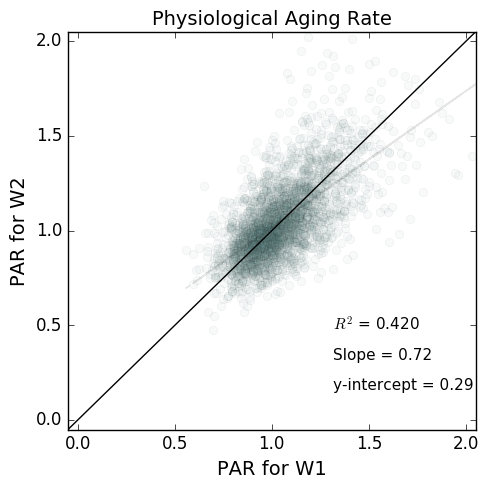

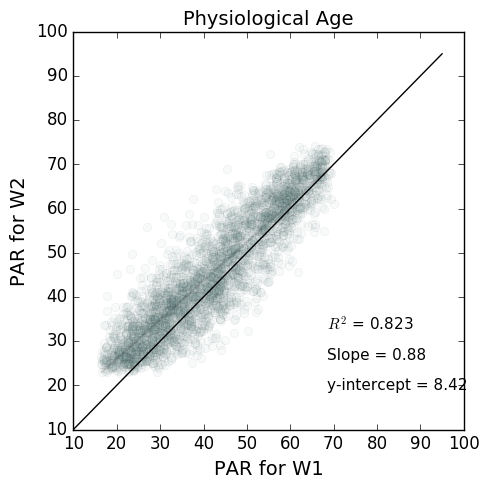

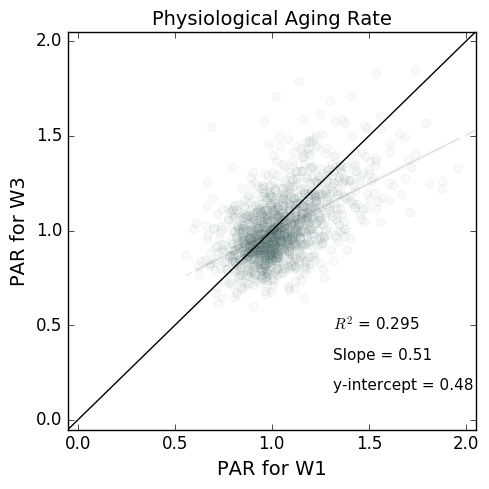

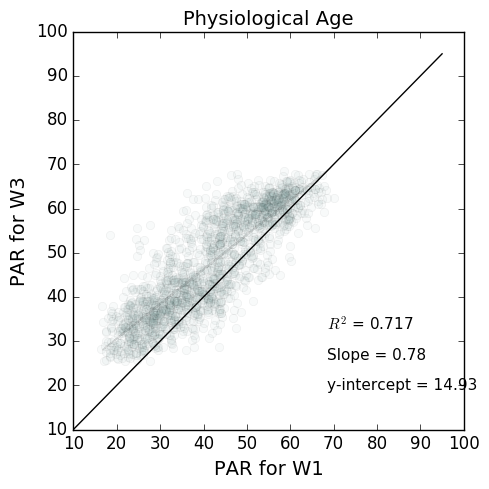

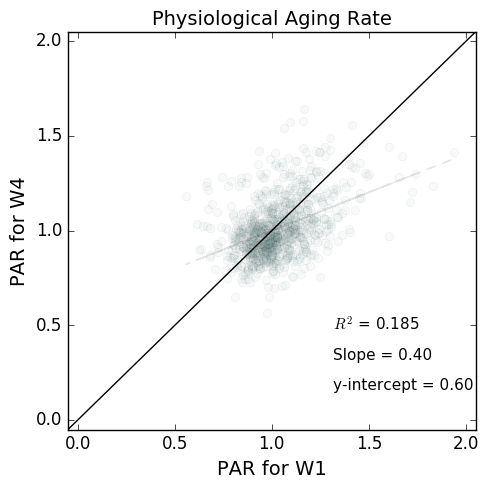

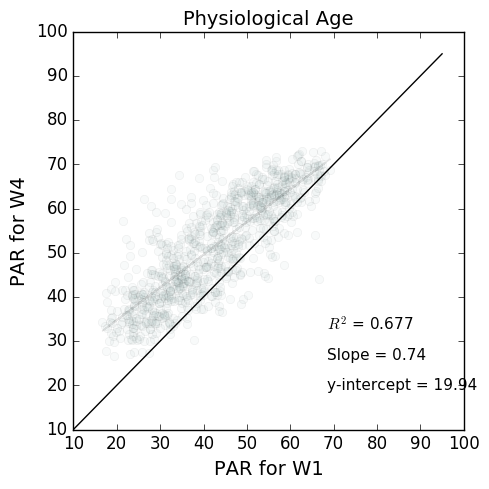

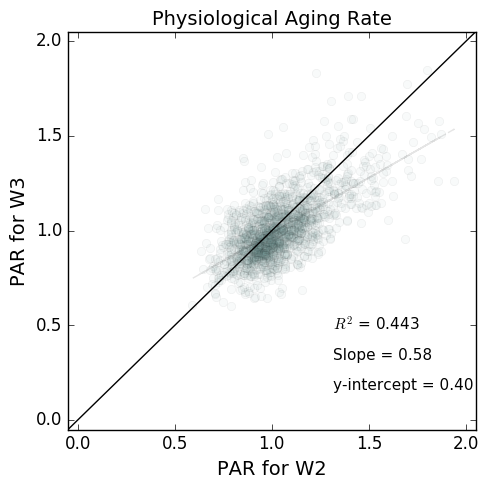

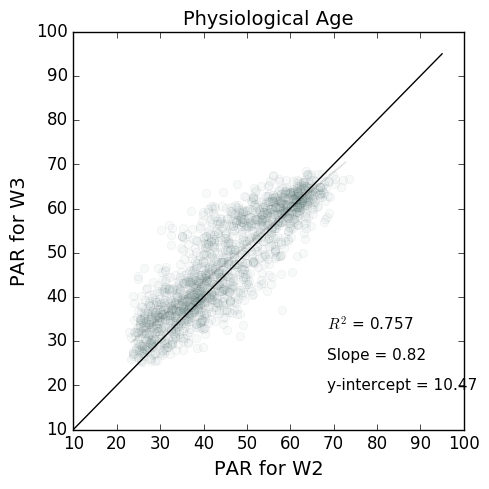

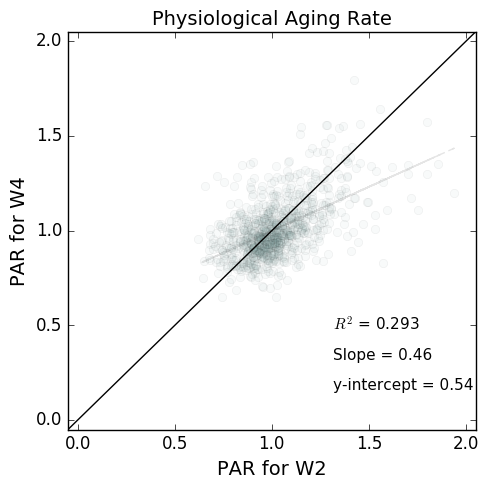

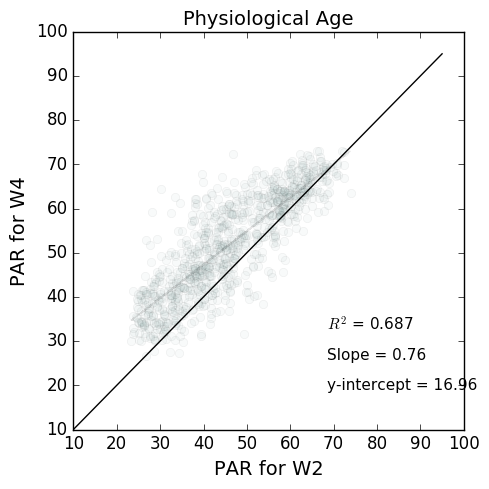

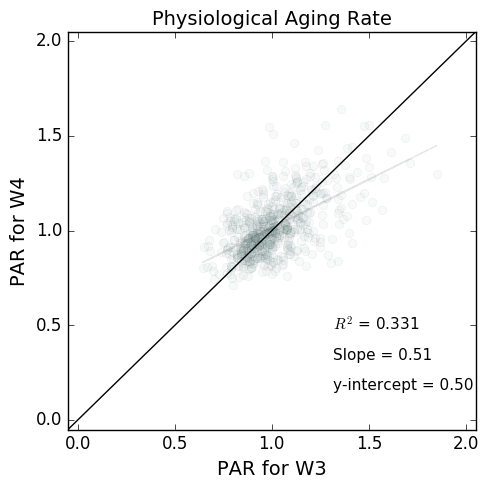

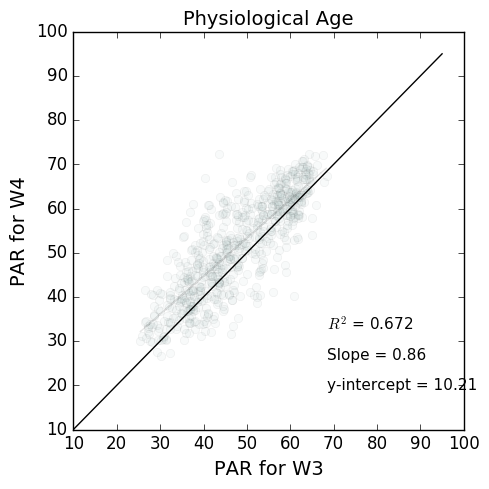

In [8]:
plotComparison('SardiNIA/wave1_normal_rf', 'SardiNIA/wave2_normal_rf', 'W12_rfc_10k_newest', x_label='PAR for W1', y_label='PAR for W2')
plotComparison('SardiNIA/wave1_normal_rf', 'SardiNIA/wave3_normal_rf', 'W13_rfc_10k_newest', x_label='PAR for W1', y_label='PAR for W3')
plotComparison('SardiNIA/wave1_normal_rf', 'SardiNIA/wave4_normal_rf', 'W14_rfc_10k_newest', x_label='PAR for W1', y_label='PAR for W4')
plotComparison('SardiNIA/wave2_normal_rf', 'SardiNIA/wave3_normal_rf', 'W23_rfc_10k_newest', x_label='PAR for W2', y_label='PAR for W3')
plotComparison('SardiNIA/wave2_normal_rf', 'SardiNIA/wave4_normal_rf', 'W24_rfc_10k_newest', x_label='PAR for W2', y_label='PAR for W4')
plotComparison('SardiNIA/wave3_normal_rf', 'SardiNIA/wave4_normal_rf', 'W34_rfc_10k_newest', x_label='PAR for W3', y_label='PAR for W4')

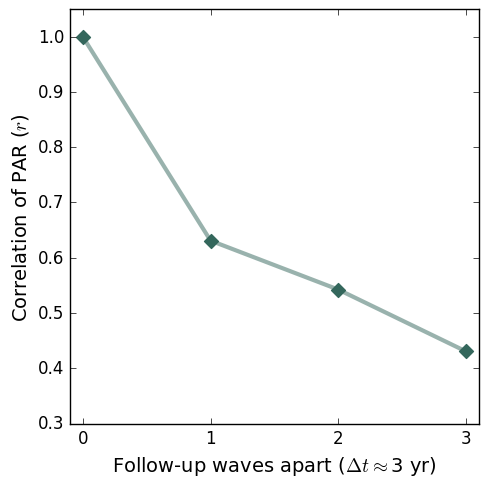

In [14]:
# Plot of R with delta_t
R2_list = [1, (0.4198+0.4430+0.3314)/3, (0.2951+0.2931)/2, 0.1852]
stdevs = [float('nan'), np.std([0.4198,0.4430,0.3314]), np.std([0.2951,0.2931]),float('nan')]
delta_t = [0,1,2,3]

r_list = [np.sqrt(r2) for r2 in R2_list]

ax = pl.figure(figsize=(5,5)).gca()
pl.scatter(delta_t,r_list,color='#34675C',s=50,marker='D',alpha=1.0)
#pl.errorbar(delta_t,r_list,yerr=stdevs,color='k',alpha=0.5)
pl.plot(delta_t,r_list,color='#34675C',alpha=0.5,linewidth=3)
pl.xlabel(r'Follow-up waves apart ($\Delta t \approx $3 yr)', fontsize=14)
pl.ylabel('Correlation of PAR ($r$)',fontsize=14)
pl.xlim(-0.1,3.1)
pl.ylim(0.3,1.05)
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.tight_layout()
pl.savefig('./Figures/Reprod_r_delta_t.png', dpi=800)
pl.show()

### SardiNIA 65-trait

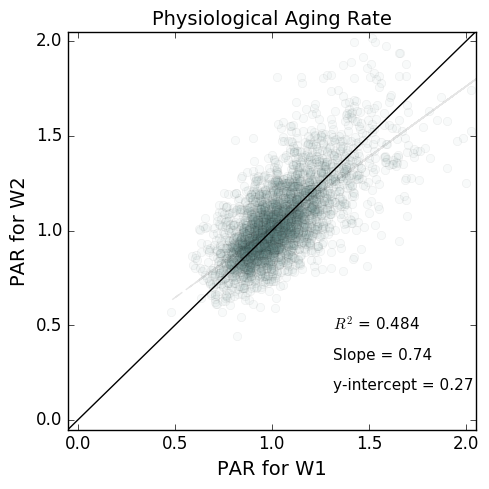

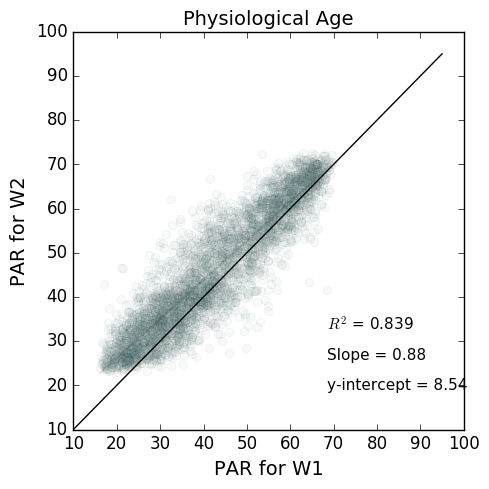

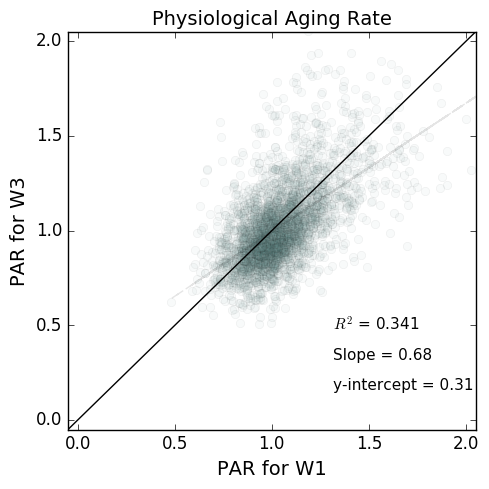

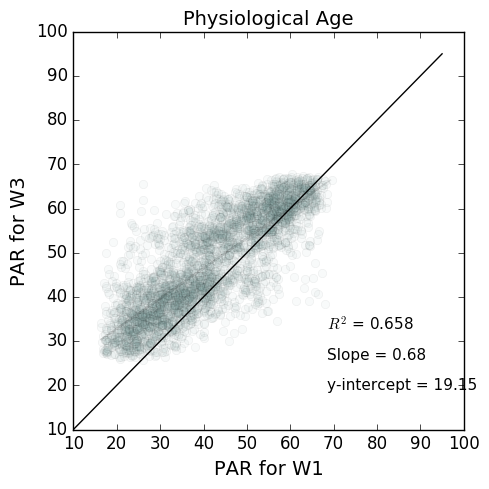

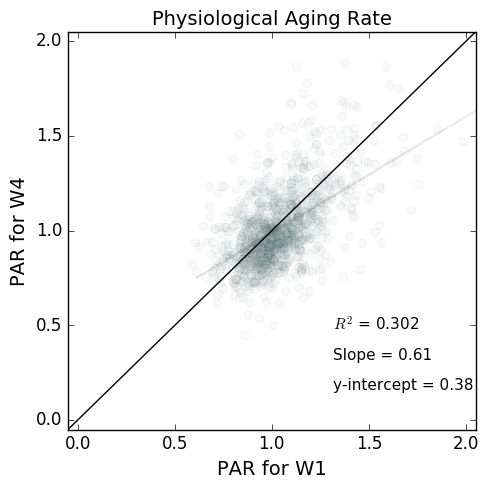

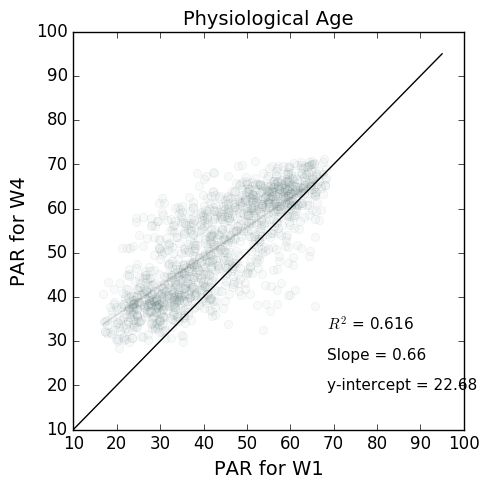

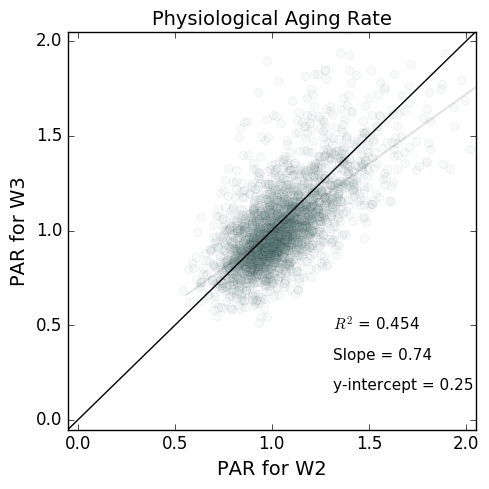

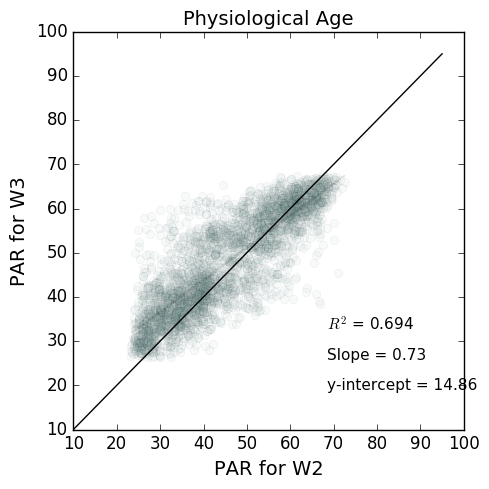

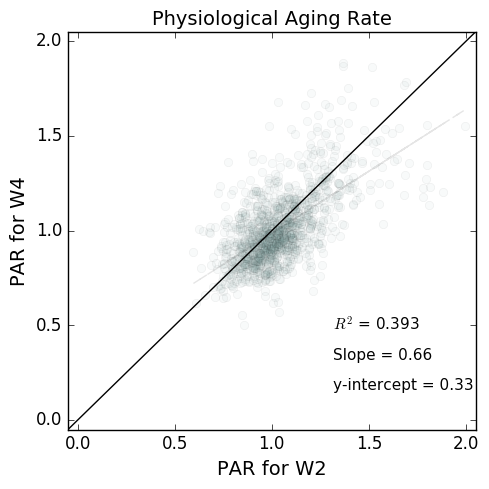

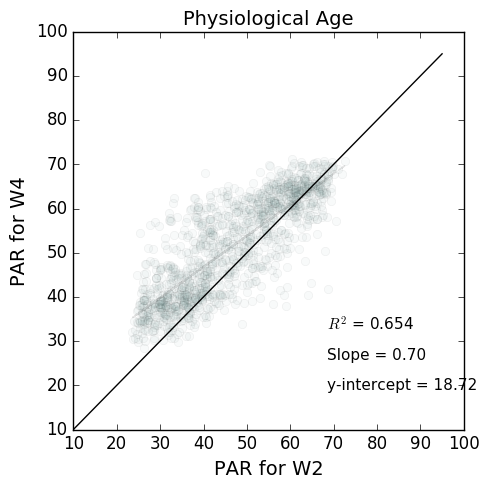

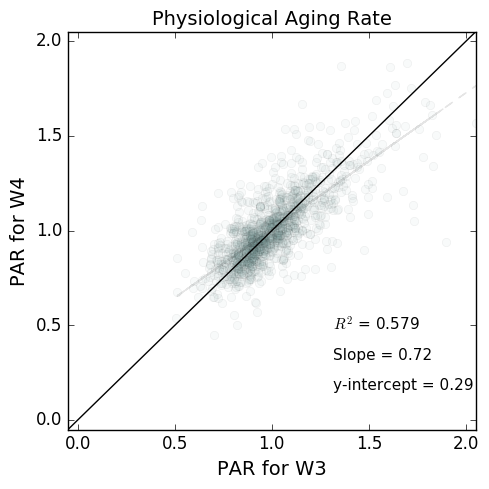

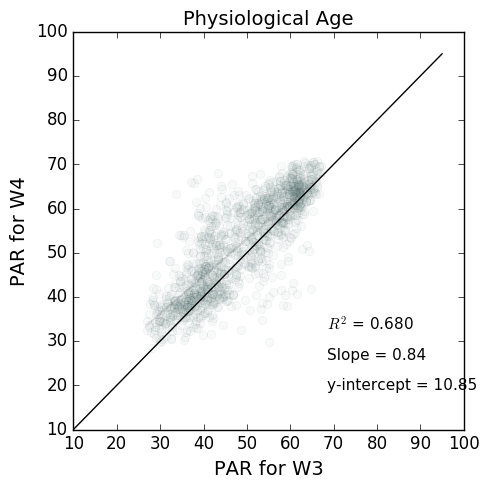

In [9]:
plotComparison('SardiNIA/wave1_common_rf', 'SardiNIA/wave2_common_rf', 'W12_rfc_comm_10k_newest', x_label='PAR for W1', y_label='PAR for W2')
plotComparison('SardiNIA/wave1_common_rf', 'SardiNIA/wave3_common_rf', 'W13_rfc_comm_10k_newest', x_label='PAR for W1', y_label='PAR for W3')
plotComparison('SardiNIA/wave1_common_rf', 'SardiNIA/wave4_common_rf', 'W14_rfc_comm_10k_newest', x_label='PAR for W1', y_label='PAR for W4')
plotComparison('SardiNIA/wave2_common_rf', 'SardiNIA/wave3_common_rf', 'W23_rfc_comm_10k_newest', x_label='PAR for W2', y_label='PAR for W3')
plotComparison('SardiNIA/wave2_common_rf', 'SardiNIA/wave4_common_rf', 'W24_rfc_comm_10k_newest', x_label='PAR for W2', y_label='PAR for W4')
plotComparison('SardiNIA/wave3_common_rf', 'SardiNIA/wave4_common_rf', 'W34_rfc_comm_10k_newest', x_label='PAR for W3', y_label='PAR for W4')

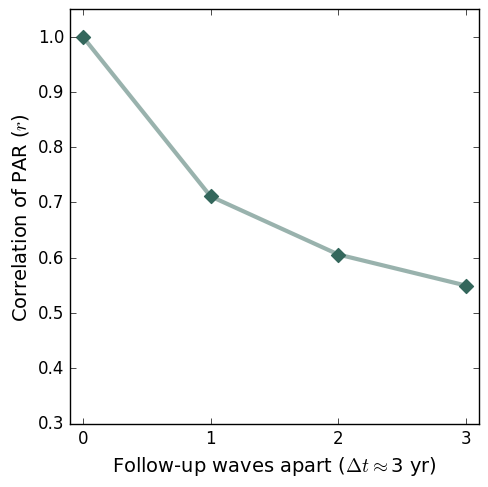

In [10]:
# Plot of R with delta_t
R2_list = [1, (0.484+0.454+0.579)/3, (0.341+0.393)/2, 0.302]
delta_t = [0,1,2,3]

r_list = [np.sqrt(r2) for r2 in R2_list]

ax = pl.figure(figsize=(5,5)).gca()
pl.scatter(delta_t,r_list,color='#34675C',s=50,marker='D',alpha=1.0)
pl.plot(delta_t,r_list,color='#34675C',alpha=0.5,linewidth=3)
pl.xlabel(r'Follow-up waves apart ($\Delta t \approx $3 yr)', fontsize=14)
pl.ylabel('Correlation of PAR ($r$)',fontsize=14)
pl.xlim(-0.1,3.1)
pl.ylim(0.3,1.05)
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.tight_layout()
pl.savefig('./Figures/Reprod_r_delta_t_common.png', dpi=800)
pl.show()

### inCHIANTI

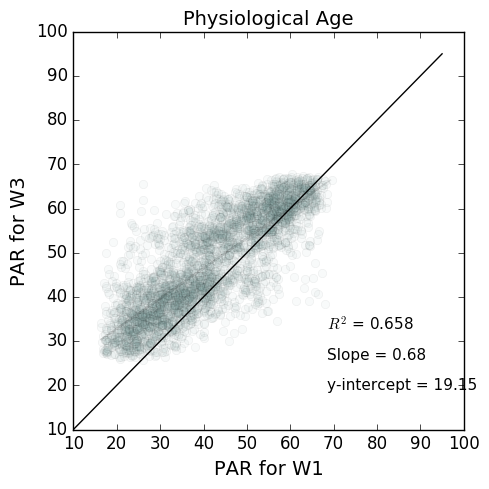

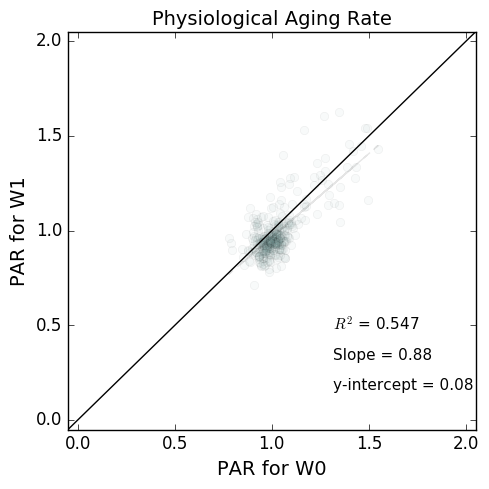

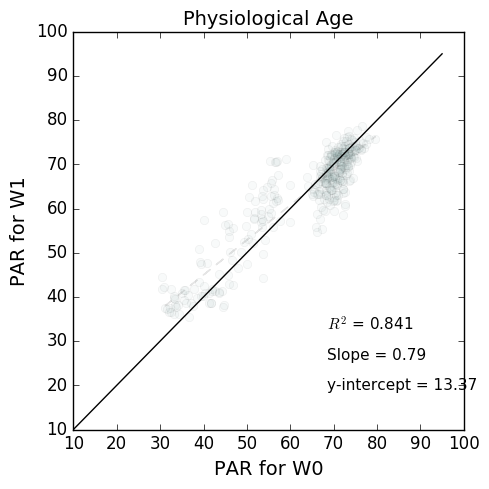

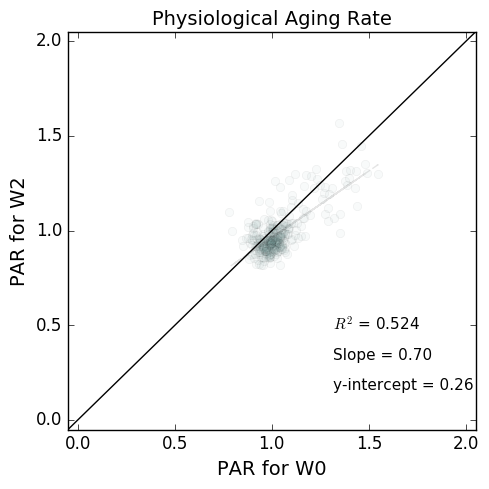

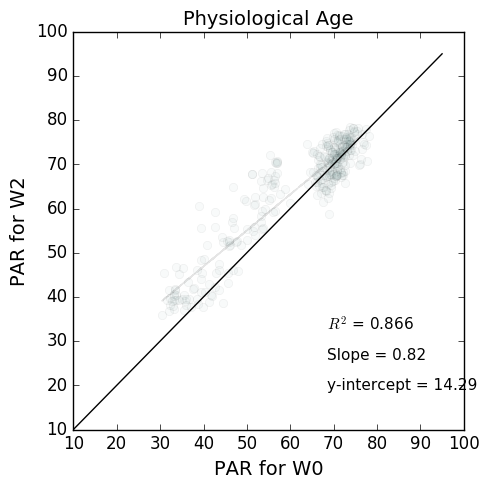

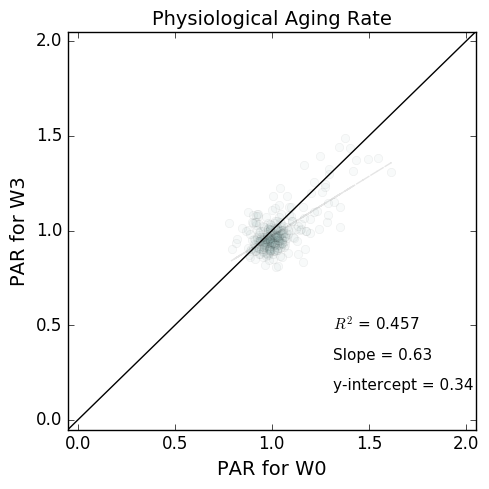

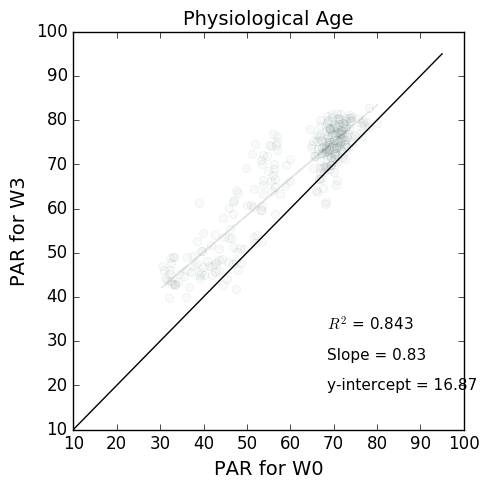

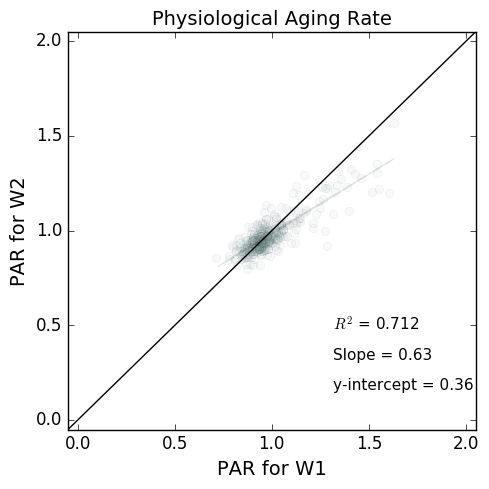

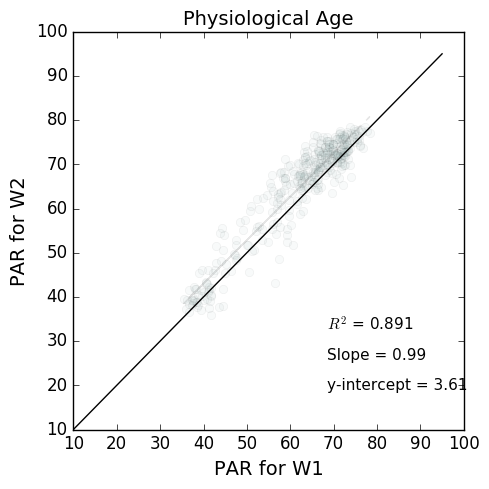

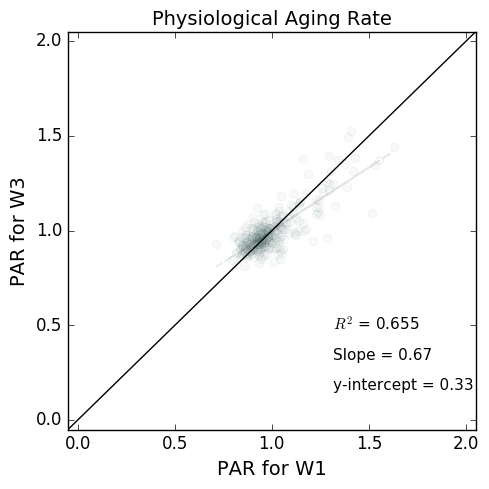

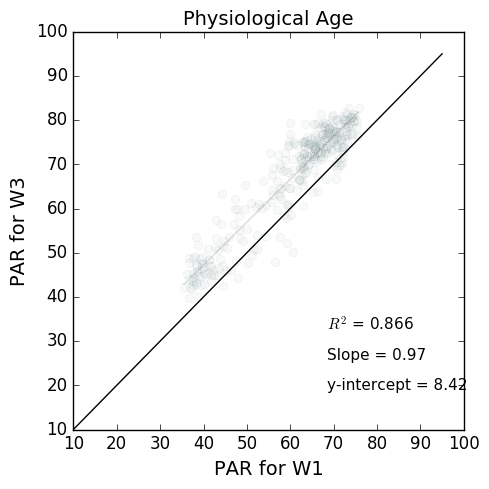

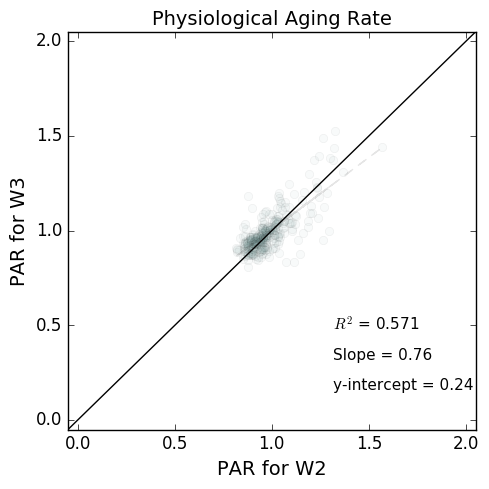

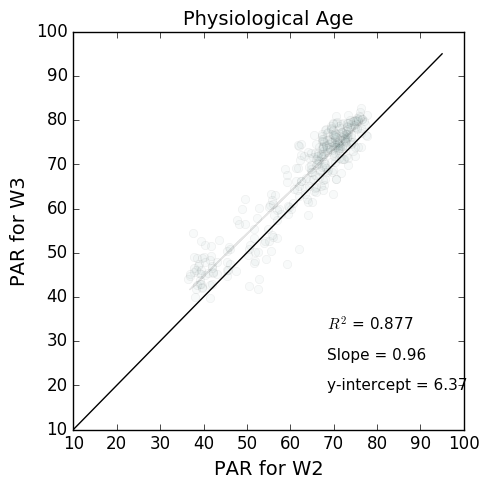

In [8]:
plotComparison('inCHIANTI/wave0_inchianti_rf', 'inCHIANTI/wave1_inchianti_rf', 'W01_rfc_inCH_10k_newest', x_label='PAR for W0', y_label='PAR for W1')
plotComparison('inCHIANTI/wave0_inchianti_rf', 'inCHIANTI/wave2_inchianti_rf', 'W02_rfc_inCH_10k_newest', x_label='PAR for W0', y_label='PAR for W2')
plotComparison('inCHIANTI/wave0_inchianti_rf', 'inCHIANTI/wave3_inchianti_rf', 'W03_rfc_inCH_10k_newest', x_label='PAR for W0', y_label='PAR for W3')
plotComparison('inCHIANTI/wave1_inchianti_rf', 'inCHIANTI/wave2_inchianti_rf', 'W12_rfc_inCH_10k_newest', x_label='PAR for W1', y_label='PAR for W2')
plotComparison('inCHIANTI/wave1_inchianti_rf', 'inCHIANTI/wave3_inchianti_rf', 'W13_rfc_inCH_10k_newest', x_label='PAR for W1', y_label='PAR for W3')
plotComparison('inCHIANTI/wave2_inchianti_rf', 'inCHIANTI/wave3_inchianti_rf', 'W23_rfc_inCH_10k_newest', x_label='PAR for W2', y_label='PAR for W3')

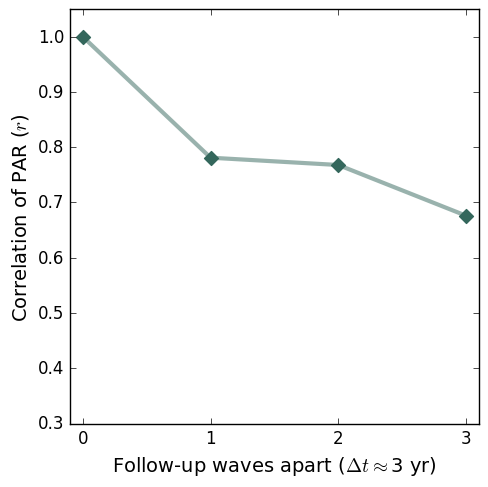

In [11]:
# Plot of R with delta_t
R2_list = [1, (0.547+0.712+0.571)/3, (0.524+0.655)/2, 0.457]
delta_t = [0,1,2,3]

r_list = [np.sqrt(r2) for r2 in R2_list]

ax = pl.figure(figsize=(5,5)).gca()
pl.scatter(delta_t,r_list,color='#34675C',s=50,marker='D',alpha=1.0)
pl.plot(delta_t,r_list,color='#34675C',alpha=0.5,linewidth=3)
pl.xlabel(r'Follow-up waves apart ($\Delta t \approx $3 yr)', fontsize=14)
pl.ylabel('Correlation of PAR ($r$)',fontsize=14)
pl.xlim(-0.1,3.1)
pl.ylim(0.3,1.05)
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.tight_layout()
pl.savefig('./Figures/Reprod_r_delta_t_inCH.png', dpi=800)
pl.show()

# PAR trajectories by wave

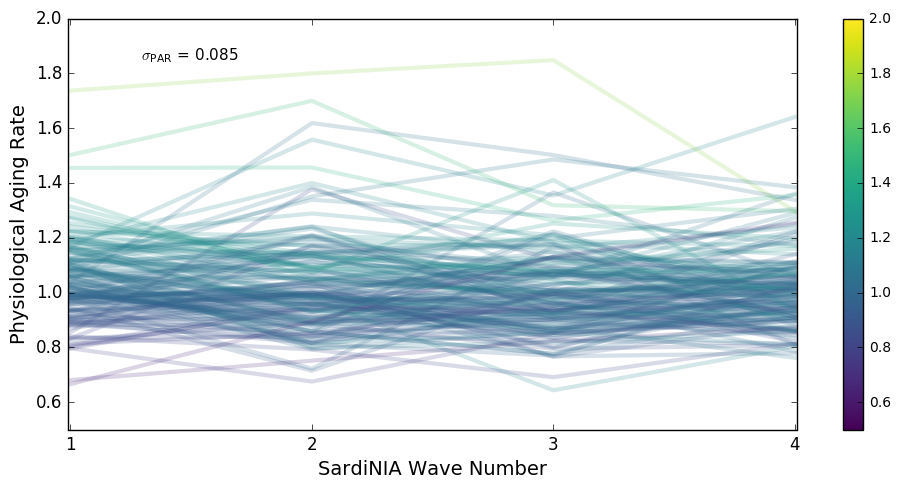

In [39]:
plotWaves('./Results/SardiNIA/normal_rf/', '', 150, 150, 'rf_norm_150_150_traj')

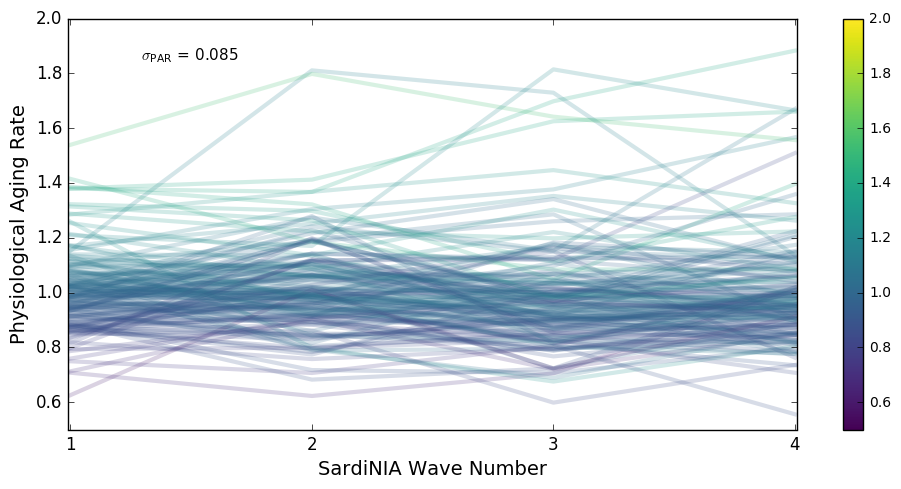

In [12]:
plotWaves('./Results/SardiNIA/common_rf/', '', 150, 150, 'rf_comonm_150_150_traj')

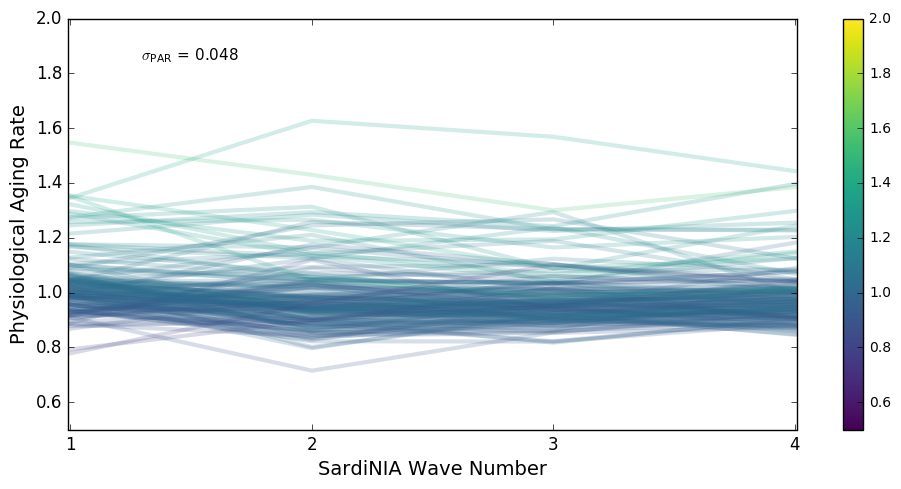

In [55]:
plotWaves('./Results/inCHIANTI/normal_rf/', '', 150, 0, 'inCH_rf_norm_150_150_traj')

## Plot trajectories by age

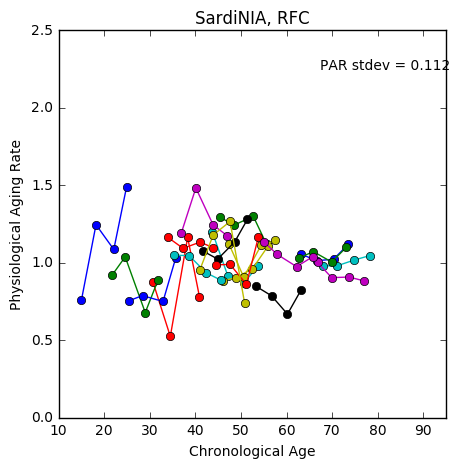

In [48]:
plotTrajectories('./Results/SardiNIA/normal_rf/', 'SardiNIA, RFC', 20, 157, 'rfc_20_157_traj')

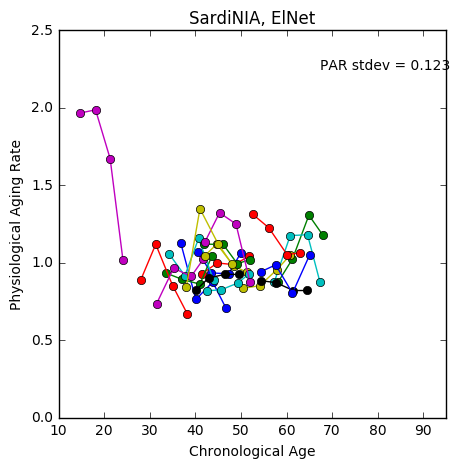

In [49]:
plotTrajectories('./Results/SardiNIA/normal_en/', 'SardiNIA, ElNet', 20, 200, 'en_20_200_traj')

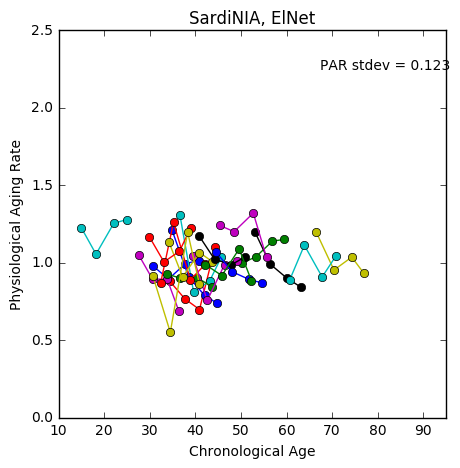

In [50]:
plotTrajectories('./Results/SardiNIA/normal_en/', 'SardiNIA, ElNet', 20, 140, 'en_20_140_traj')

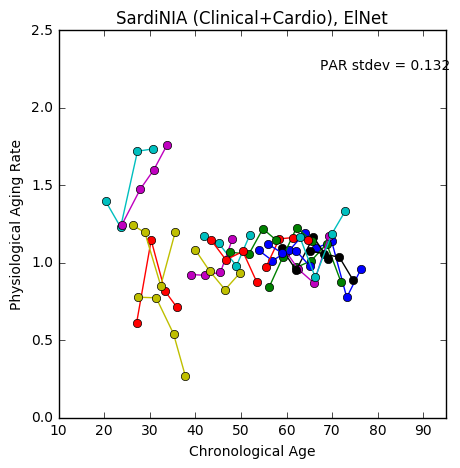

In [51]:
plotTrajectories('./Results/SardiNIA/common_en/', 'SardiNIA (Clinical+Cardio), ElNet', 20, 200, 'en_comm_20_200_traj')

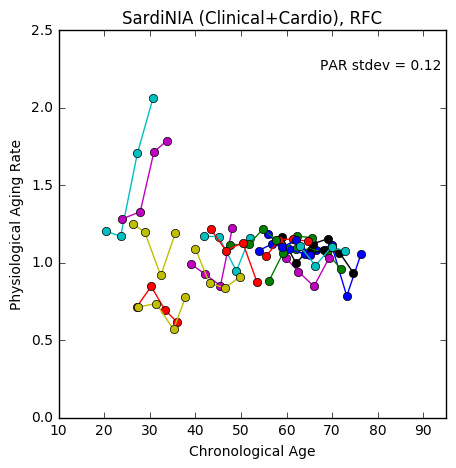

In [52]:
plotTrajectories('./Results/SardiNIA/common_rf/', 'SardiNIA (Clinical+Cardio), RFC', 20, 200, 'rf_comm_20_200_traj')

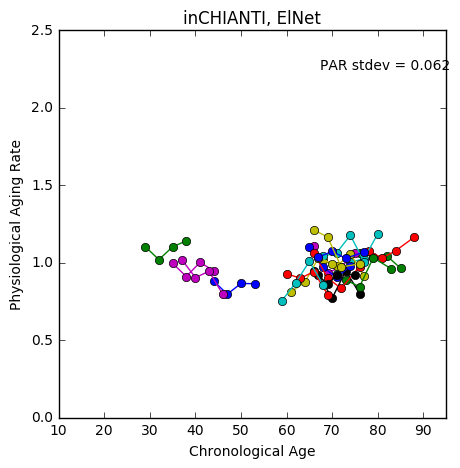

In [53]:
plotTrajectories('./Results/inCHIANTI/normal_en/', 'inCHIANTI, ElNet', 20, 100, 'en_inCH_20_100_traj')

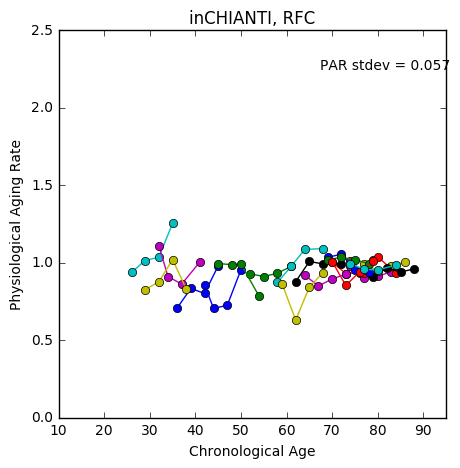

In [54]:
plotTrajectories('./Results/inCHIANTI/normal_rf/', 'inCHIANTI, RFC', 20, 80, 'rf_inCH_20_80_traj')